<h2 style="color:lightgreen">Random Forests</h2>


In [1]:
from train import *
from accuracy import *
import random
from statistics import mode
import traceback
import seaborn as sn
import matplotlib.pyplot as plt


<h3> Dataset Management </h3>

<div>
<h4 style="color:gray;" >
The dataset contains a few rows and columns with missing values. The big disadvantage is that the evaluation of the model, in regards to CART(Classication and Regression Trees), is subject to dramatic changes with slight manipulation of data. It is ,infact, the very reason why decision trees are not used in instances where the table is mallaeble. However, since the table has a few of those missing values, we decided to just ignore them completely without compromising the accuracy of the model</h4>
    
</div>

In [2]:
class Random_Forest:
    def __init__(self):
        self.p_features = ["Irradiat","Age","Menopause","Tumor-Size","Inv-Node","Node-Caps","Deg-Malig","Breast","Breast-Quad","Class"]
        self.missing_values = ["Node-Caps","Breast-Quad"]
        self.missing_value = self.missing_values[0]
        self.trees = 20
        
        
    def fill_most(self,dataset):
        node_caps_top =  dataset['Node-Caps'].describe()['top']
        breast_quad_top = dataset['Breast-Quad'].describe()['top']
        tops = [node_caps_top,breast_quad_top]
        for missing_value,top in zip(self.missing_values,tops):
            if dataset[missing_value].isnull().sum() > 0:
                dataset[missing_value].replace(np.NaN,top,inplace=True)
        return dataset

In [3]:
def organize_dataset(csv,features,p_features):
        dataset = pd.read_csv(csv, header=None, names=features)
        if True in ["?" in list(dataset[x].unique()) for x in dataset.columns]:
            dataset = dataset[features].replace("?", np.NaN)
        return dataset[p_features]
    
def reorganize_dataset(dataset,missing_value):
        dataset = dataset.drop('Class', 1)
        new_features = list(dataset.columns)
        f_index = new_features.index(missing_value)
        new_features[f_index], new_features[-1] = new_features[-1], new_features[f_index]
        return new_features    

def drop_values(dataset):
    return dataset.dropna(how="any").reset_index(drop=True)
    
    
def split_reorganized_dataset(dataset,missing_value):
        train_filter = dataset[missing_value] != "?"
        test_filter = dataset[missing_value] == "?"
        train_dataset = dataset[train_filter]
        test_dataset = dataset[test_filter]
        train_class_values = train_dataset.loc[:, 'Class']
        test_class_values = test_dataset.loc[:, 'Class']
        return train_dataset, test_dataset, train_class_values, test_class_values

def input_value_into_test_dataset(x_test,missing_value,predicted_values):
        dataset = x_test.drop(missing_value, 1)
        cols = len(x_test.columns)
        dataset.insert(cols - 1, missing_value, predicted_values)
        return dataset
    
def merge_datasets(x_train,x_test,c_train,c_test,re_features,p_features,missed_value):
        x_train = x_train[re_features]
        x_test = x_test[re_features]
        model = ID3(x_train,x_train)
        predicted_values = predict_dataset(model,x_test)
        new_xtest = input_value_into_test_dataset(x_test,missed_value,predicted_values)
        new_training_data = pd.concat([x_train, c_train], axis=1)
        new_testing_data = pd.concat([new_xtest, c_test], axis=1)
        new_dataset = pd.concat([new_training_data, new_testing_data], axis=0)
        return new_dataset.sort_index()[p_features]
    
def split_dataset(dataset):
    split = len(dataset) * 70//100
    train_data = dataset[:split]
    test_data = dataset[split:]
    return train_data,test_data

In [4]:
org_features = ["Class","Age","Menopause","Tumor-Size","Inv-Node","Node-Caps","Deg-Malig","Breast","Breast-Quad","Irradiat"]
features = ["Irradiat","Age","Menopause","Tumor-Size","Inv-Node","Node-Caps","Deg-Malig","Breast","Breast-Quad"]
features_wc = ["Irradiat","Age","Menopause","Tumor-Size","Inv-Node","Node-Caps","Deg-Malig","Breast","Breast-Quad","Class"]
dataset = pd.read_csv("breast-cancer.csv",sep=",",header=None,names=org_features)

# Swap last column and first column - ID3 algorithm takes last column as class
ndataset = dataset[features_wc]
ndataset = ndataset.sample(frac=1)
filter_dataset = ndataset.replace("?",np.NaN)


# Remove all of the NaN values
drop_filter_dataset = filter_dataset.dropna(how="any").reset_index(drop=True)

In [5]:
features = ["Class","Age","Menopause","Tumor-Size","Inv-Node","Node-Caps","Deg-Malig","Breast","Breast-Quad","Irradiat"]
p_features = ["Irradiat","Age","Menopause","Tumor-Size","Inv-Node","Node-Caps","Deg-Malig","Breast","Breast-Quad","Class"]
csv = 'breast-cancer.csv'
rr = Random_Forest()
dataset = pd.read_csv(csv,header=None,names=features)[p_features]
mix_dataset = dataset.sample(frac=1)

# fill most dataset
fill_most_dataset = rr.fill_most(organize_dataset(csv,features,p_features))
mix_fill_most_dataset = fill_most_dataset.sample(frac=1)

#drop dataset
drop_dataset = drop_values(organize_dataset(csv,features,p_features))
mix_drop_dataset = drop_dataset.sample(frac=1)

x_train, x_test, c_train, c_test = split_reorganized_dataset(dataset,"Node-Caps")
re_features = reorganize_dataset(dataset,"Node-Caps")
classifier_dataset = merge_datasets(x_train,x_test,c_train,c_test,re_features,p_features,"Node-Caps")
mix_classifier_dataset = classifier_dataset.sample(frac=1)


In [6]:
#Original Dataset
train_mix_dataset,test_mix_dataset = split_dataset(mix_dataset)

# Drop dataset
train_mix_drop_dataset,test_mix_drop_dataset = split_dataset(mix_drop_dataset)

#Fill Most Dataset
train_mix_fill_most_dataset,test_mix_fill_most_dataset = split_dataset(mix_fill_most_dataset)

#Classifier Dataset
train_mix_classifier_dataset,test_mix_classifier_dataset = split_dataset(mix_classifier_dataset)


In [7]:
def split_data(dataset):
	split = len(dataset) * 75//100
	train = dataset.iloc[:split].reset_index(drop=True)
	test = dataset.iloc[split:].reset_index(drop=True)
	return [train,test]


In [8]:
def random_forest(dataset,num_trees):
	random_forest = []
	for i in range(num_trees):
		bootstrap_sample = dataset.sample(frac=1,replace=True)

		bootstrap_train = split_data(bootstrap_sample)[0]
		bootstrap_test = split_data(bootstrap_sample)[1]


		tree = decision_tree(bootstrap_train)
		random_forest.append(tree)

	return random_forest


<h3>Random Trees use a technique called bagging , or bootstrap aggregration, which decides it prediction based on which class occurs the most within a feature sppace</h3>

In [9]:
def get_mode(leaves):
	unique_values = np.unique(leaves,return_counts=True)[1]
	ans = True
	value = unique_values[0]
	for x in unique_values:
		if x != value:
			ans  = False 
	if ans == True:
		return leaves[0]
	else:
		return mode(leaves)

def get_leaves(tree,features=[]):

	for k,v in tree.items():
		if isinstance(v,dict):
			get_leaves(v,features)
		else:
			# k is the ket
			features.append(v)

	return features

In [10]:
########################################## Predictions ###########################################################
def predict(query,model,default = "no-recurrence-events"):
    events = ["no-recurrence-events","recurrence-events"]
    if isinstance(model,str):
    	return model
    else:
	    for key in list(query.keys()):
	    	#Check if the feature name exists in the model features
	        if key in list(model.keys()):
	            try:
	            	# Attempt to get the value of the "first" feature
	                result = model[key][query[key]]
	            except:
	            	#If the model does have the value, return 1
	            	#Return down the stack trace
	                return random.choice(events)
	            #Get the resulting model or value
	            #If it's model then keep going
	            #else just return the result
	            result = model[key][query[key]]
	            if isinstance(result,dict):
	                return predict(query,result)
	            else:
	                return result

def predict_dataset(model,test_data):
	prediction_values = []
	queries = test_data.iloc[:,:-1].to_dict(orient="records")
	for i in range(len(test_data)):
		prediction_values.append(predict(queries[i],model))	
	return prediction_values

def query_prediction(forest,query):
	predictions = []
	for tree in forest:
		predictions.append(predict(query,tree))
	return get_mode(predictions)


def forest_predict(forest,queries):
	forest_pred = []
	for row in range(len(queries)):
		forest_pred.append(query_prediction(forest,queries[row]))
	return forest_pred


# def dec_mode(model,testing_data):
# 	return predict_dataset(model.)

def ensemble(forest,testing_data):
	forest_mode = []
	for tree in forest:
		pred = predict_dataset(tree,testing_data)
		model_mode = get_mode(pred)
		forest_mode.append(model_mode)
	return forest_mode

In [11]:
#Accuracy
#Assumes cost
def accuracy(TP,TN,FP,FN):
	numerator = TP + TN
	denominator = TP + TN + FP + FN
	return numerator/denominator
	

# When it actually says, i.e real data
#how often does it predict yes
def recall(TP,FN):
  return TP/(TP+FN)


#When it predicts yes , how often
def precision(TP,FP):
	return TP/(TP+FP)




def f_measure(recall,precision):
	numerator = 2* recall * precision
	denominator = recall + precision
	return numerator / denominator


def convert_first(class_list):
	class_dict = {"recurrence-events":1,"no-recurrence-events":0}
	class_list = [class_dict[item] for item in class_list]
	return class_list

def convert(class_list):
	class_unique = np.unique(class_list)
	class_dict = {}
	for index in range(len(class_unique)):
		class_dict[class_unique[index]] = index

	class_list =  [class_dict[item] for item in class_list]
	return class_list


# def forest_accuracy(forest,queries,testing_data):
#     forest_pred = forest_predict(forest,queries)
#     convert_pred = convert(forest_pred)
#     actual = list(testing_data.iloc[:,-1])
#     convert_act = convert(actual)
#     data = {"y_act":convert_act,"y_pred":convert_pred}
#     df = pd.DataFrame(data,columns = ["y_act","y_pred"])
#     conf_matrix = pd.crosstab(df["y_act"],df["y_pred"],rownames=["Actual"],colnames=["Predicted"],margins=True,margins_name="Total")
# #     return conf_matrix
# 	sum_check = conf_matrix[0][0] + conf_matrix[0][1]
# 	if sum_check != len(testing_data):
# 		TP = conf_matrix[1][1]
# 		TN = conf_matrix[0][0]
# 		FP = conf_matrix[1][0]
# 		FN = conf_matrix[0][1]

# 		########################## Calculations ################################################
# 		acc = accuracy(TP,TN,FP,FN)
# 		recall_data = recall(TP,FN)
# 		precision_data = precision(TP,FP)
# 		f_measure_data = f_measure(recall_data,precision_data)
# 		########################## Calculations ################################################
# 		return ({"Accuracy":acc, "Recall":recall_data,"Precision":precision_data,"F Measure":f_measure_data},conf_matrix)
# 	else:
#         return conf_matrix

    
    

def forest_accuracy(forest,queries,testing_data):
    forest_pred = forest_predict(forest,queries)
    convert_pred = convert(forest_pred)
    actual = list(testing_data.iloc[:,-1])
    convert_act = convert(actual)
    data = {"y_act":convert_act,"y_pred":convert_pred}
    df = pd.DataFrame(data,columns = ["y_act","y_pred"])
    conf_matrix = pd.crosstab(df["y_act"],df["y_pred"],rownames=["Actual"],colnames=["Predicted"],margins=True,margins_name="Total")

    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[1][0]
    FN = conf_matrix[0][1]

    ########################## Calculations ################################################
    acc = accuracy(TP,TN,FP,FN)
    recall_data = recall(TP,FN)
    precision_data = precision(TP,FP)
    f_measure_data = f_measure(recall_data,precision_data)
    ########################## Calculations ################################################
    return ({"Accuracy":acc, "Recall":recall_data,"Precision":precision_data,"F Measure":f_measure_data},conf_matrix)

def show_heatmap(conf_matrix):
	sn.heatmap(conf_matrix,annot=True)
	plt.title("Breast Cancer: Confusion Matrix")
	plt.show()



In [33]:
fs_features =  ["Tumor-Size","Inv-Node","Node-Caps","Irradiat","Class"]
fs_classifier = mix_classifier_dataset[fs_features]
fs_train_mix_drop_dataset,fs_test_mix_drop_dataset = split_dataset(mix_drop_dataset[fs_features])
fs_train_mix_fill_most_dataset,fs_test_mix_fill_most_dataset = split_dataset(mix_fill_most_dataset[fs_features])
fs_train_mix_classifier,fs_test_mix_classifier = split_dataset(mix_classifier_dataset[fs_features])

Accuracy:66.67 %


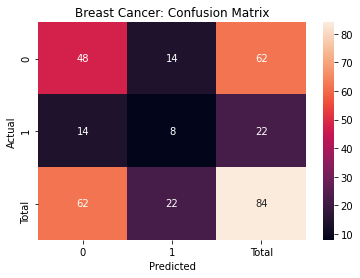

Accuracy:76.19 %


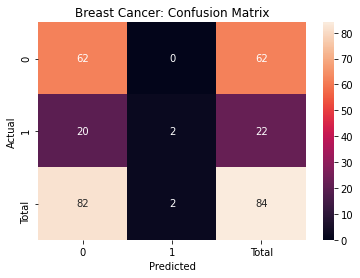

In [34]:
# training_data = split_data(drop_dataset)[0]
# testing_data = split_data(drop_dataset)[1]
drop_queries = test_mix_drop_dataset.iloc[:,:-1].to_dict(orient="records")
drop_forest = random_forest(train_mix_drop_dataset,rr.trees)
drop_accuracy = forest_accuracy(drop_forest,drop_queries,test_mix_drop_dataset)
percent = np.round(drop_accuracy[0]['Accuracy'] * 100,2)
print("Accuracy:{} %".format(percent))
show_heatmap(drop_accuracy[1])


fs_drop_queries = fs_test_mix_drop_dataset.iloc[:,:-1].to_dict(orient="records")
fs_drop_forest = random_forest(fs_test_mix_drop_dataset,rr.trees)
fs_drop_accuracy = forest_accuracy(fs_drop_forest,fs_drop_queries,fs_test_mix_drop_dataset)
percent = np.round(fs_drop_accuracy[0]['Accuracy'] * 100,2)
print("Accuracy:{} %".format(percent))
show_heatmap(fs_drop_accuracy[1])


Accuracy:74.42 %


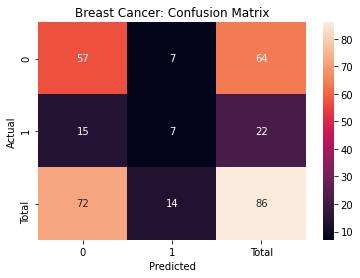

Accuracy:74.42 %


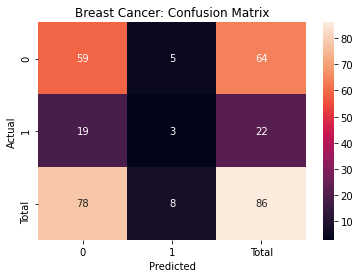

In [35]:
fill_queries = test_mix_fill_most_dataset.iloc[:,:-1].to_dict(orient="records")
fill_forest = random_forest(train_mix_fill_most_dataset,rr.trees)
fill_accuracy = forest_accuracy(fill_forest,fill_queries,test_mix_fill_most_dataset)
percent = np.round(fill_accuracy[0]['Accuracy'] * 100,2)
print("Accuracy:{} %".format(percent))
show_heatmap(fill_accuracy[1])



fs_fill_queries = fs_test_mix_fill_most_dataset.iloc[:,:-1].to_dict(orient="records")
fs_fill_forest = random_forest(fs_train_mix_fill_most_dataset,rr.trees)
fs_fill_accuracy = forest_accuracy(fs_fill_forest,fs_fill_queries,fs_test_mix_fill_most_dataset)
fs_fill_most_percent = np.round(fs_fill_accuracy[0]['Accuracy'] * 100,2)
print("Accuracy:{} %".format(percent))
show_heatmap(fs_fill_accuracy[1])

Accuracy:73.26 %


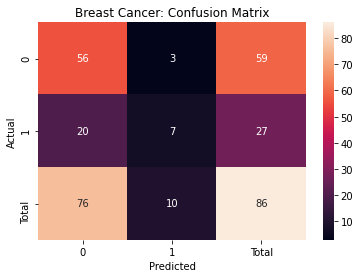

Accuracy:70.93 %


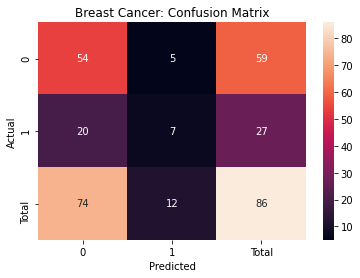

In [37]:
cls_queries = test_mix_classifier_dataset.iloc[:,:-1].to_dict(orient="records")
cls_forest = random_forest(classifier_dataset,rr.trees)
cls_accuracy = forest_accuracy(cls_forest,cls_queries,test_mix_classifier_dataset)
percent = np.round(cls_accuracy[0]['Accuracy'] * 100,2)
print("Accuracy:{} %".format(percent))
show_heatmap(cls_accuracy[1])



fs_cls_queries = fs_test_mix_classifier.iloc[:,:-1].to_dict(orient="records")
fs_cls_forest = random_forest(fs_classifier,rr.trees)
fs_cls_accuracy = forest_accuracy(fs_cls_forest,fs_cls_queries,fs_test_mix_classifier)
fs_cls_percent = np.round(fs_cls_accuracy[0]['Accuracy'] * 100,2)
print("Accuracy:{} %".format(fs_cls_percent))
show_heatmap(fs_cls_accuracy[1])